In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 0.75, 11))
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
from torch import optim
from gpytorch.kernels import RBFKernel, SpectralMixtureKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class SpectralMixtureGPModel(gpytorch.GPModel):
    def __init__(self):
        super(SpectralMixtureGPModel,self).__init__(GaussianLikelihood(log_noise_bounds=(-5, 5)))
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        self.covar_module = SpectralMixtureKernel(n_mixtures=3)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return GaussianRandomVariable(mean_x, covar_x)

model = SpectralMixtureGPModel()

In [5]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 5, 51))
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        if plot_train_data:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

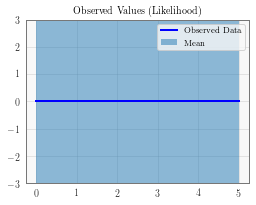

In [6]:
fig = plot_model_and_predictions(model, plot_train_data=False)

In [7]:
# Find optimal model hyperparameters
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(50):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()
    
# Set back to eval mode
_ = model.eval()

Iter 1/50 - Loss: 1.422
Iter 2/50 - Loss: 1.176
Iter 3/50 - Loss: 1.254
Iter 4/50 - Loss: 1.236
Iter 5/50 - Loss: 1.096
Iter 6/50 - Loss: 1.014
Iter 7/50 - Loss: 1.098
Iter 8/50 - Loss: 0.946
Iter 9/50 - Loss: 0.946
Iter 10/50 - Loss: 0.869
Iter 11/50 - Loss: 0.807
Iter 12/50 - Loss: 0.907
Iter 13/50 - Loss: 0.804
Iter 14/50 - Loss: 0.750
Iter 15/50 - Loss: 0.893
Iter 16/50 - Loss: 0.782
Iter 17/50 - Loss: 0.844
Iter 18/50 - Loss: 0.587
Iter 19/50 - Loss: 0.709
Iter 20/50 - Loss: 0.548
Iter 21/50 - Loss: 0.505
Iter 22/50 - Loss: 0.443
Iter 23/50 - Loss: 0.334
Iter 24/50 - Loss: 0.542
Iter 25/50 - Loss: 0.406
Iter 26/50 - Loss: 0.364
Iter 27/50 - Loss: 0.363
Iter 28/50 - Loss: 0.457
Iter 29/50 - Loss: 0.458
Iter 30/50 - Loss: 0.443
Iter 31/50 - Loss: 0.192
Iter 32/50 - Loss: 0.138
Iter 33/50 - Loss: 0.041
Iter 34/50 - Loss: 0.307
Iter 35/50 - Loss: 0.124
Iter 36/50 - Loss: 0.206
Iter 37/50 - Loss: -0.033
Iter 38/50 - Loss: 0.028
Iter 39/50 - Loss: 0.124
Iter 40/50 - Loss: 0.216
Iter 41/

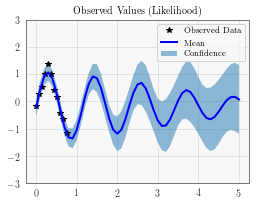

In [8]:
model.condition(train_x, train_y)
fig = plot_model_and_predictions(model)